In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
#LOADING DATASET

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

#SPLIT DATA 80-10-10 FOR TRAIN-VAL-TEST

train_len = int(0.8 * len(trainset))
val_len = len(trainset) - train_len
test_len = len(testset)

train_subset, val_subset = torch.utils.data.random_split(trainset, [train_len, val_len])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
#DEFINE LAYER SIZES

input_size = 28 * 28 #no. pixels per image
hidden_layers_sizes = [128,64] #no. nodes per hidden layer 
output_size = 10 #no. classes (digits 0-9)

#INITIALISE MODEL

model = nn.Sequential(
            nn.Linear(input_size, hidden_layers_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers_sizes[0],hidden_layers_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers_sizes[1], output_size),
            nn.LogSoftmax(dim=1))

In [ ]:
#TRAINING

criterion = nn.NLLLoss() #Negative log likelihood loss 
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

max_epochs = 15 
train_losses = []  #index is epoch no. - value is training loss on said epoch
val_losses = [] #index is epoch no. - value is validation loss on said epoch 
best_model = None #save model with best/lowest val_loss
best_epoch = 0 
best_val_loss = float('inf') 
inc_patience = 2 #allow for a max of 2 increases in validation loss in a row
loss_dec_threshhold = 0.03 #next line 
dec_patience = 2 #all for a max of 2 decreases under in validation loss in a row, which are under specified threshhold

for epoch_no in range(max_epochs):
    
    training_current_loss = 0
    for images,labels in trainloader:

        #flatten image into long vector
        images = images.view(images.shape[0], -1)

        #clear old gradient 
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps,labels)

        #backpropagation
        loss.backward()

        #adjust weights
        optimizer.step()

        training_current_loss += loss.item()
    train_losses.append(training_current_loss/len(trainloader))    #store training loss after each epoch

    validation_current_loss = 0
    for images,labels in valloader:
        
        images = images.view(images.shape[0], -1)

        #no learning to be done here 
        
        logps = model(images)
        loss = criterion(logps,labels)
        
        validation_current_loss += loss.item() 
    val_losses.append(validation_current_loss/len(valloader))    #store validation loss after each epoch 

    print("Epoch {}:".format(epoch_no))
    print("    Training loss: {}".format(training_current_loss / len(trainloader)))
    print("    Validation loss: {}".format(validation_current_loss/len(valloader)))


    #save best model by comparing validation loss with current best 
    
    if validation_current_loss < best_val_loss:                  
        best_val_loss = validation_current_loss
        best_epoch = epoch_no
        best_model_state = {
            'epoch': epoch_no,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': training_current_loss,
            'val_loss': validation_current_loss
        }
        torch.save(best_model_state, 'best_model.pth')
        continue

    #stop learning if validation loss increases too many times in a row 

    if (epoch_no > inc_patience +1) and (sum([1 if val_losses[epoch_no-i]>val_losses[epoch_no-i-1] else 0 
                                              for i in range(inc_patience+1)]) > inc_patience):
        break

    #stop learning if decreases in validation loss are too small too many times in a row 

    if (epoch_no > dec_patience + 1) and (sum( [1 if val_losses[epoch_no-i] - val_losses[epoch_no-i-1] < loss_dec_threshhold else 0 
                                                for i in range(dec_patience+1)]) > dec_patience):
        break
    
    

Epoch 0:
    Training loss: 0.7444738603035609
    Validation loss: 0.35402245851273234
Epoch 1:
    Training loss: 0.3089312360684077
    Validation loss: 0.28497549281158346
Epoch 2:
    Training loss: 0.24475898438692092
    Validation loss: 0.23189711485533637
Epoch 3:
    Training loss: 0.19971585054695606
    Validation loss: 0.2053742301154961
Epoch 4:
    Training loss: 0.16878293997297683
    Validation loss: 0.18400157688859295
Epoch 5:
    Training loss: 0.14815485732754072
    Validation loss: 0.15892102634732394
Epoch 6:
    Training loss: 0.12837944980710744
    Validation loss: 0.1544312405538686
Epoch 7:
    Training loss: 0.11384527188539505
    Validation loss: 0.1431423350871402
Epoch 8:
    Training loss: 0.10088696524004141
    Validation loss: 0.12929746647305945
Epoch 9:
    Training loss: 0.09124627367034555
    Validation loss: 0.12256024254267996


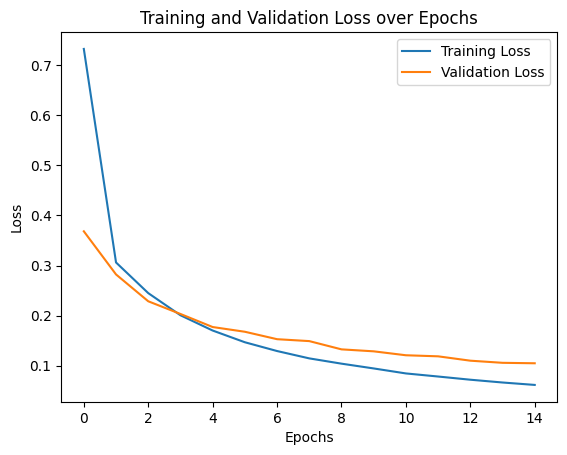

In [6]:
#DISPLAY TRAINING AND VALIDATION LOSS AT EACH EPOCH

epochs = range(0, epoch_no+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [10]:
#FUNCTION SHOWING CLASS PROBABILITY GIVEN AN IMAGE (chance of each digit)

def view_classify(img, ps):
    
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [11]:
#LOAD BEST MODEL FOUND DURING TRAINING PROCESS

checkpoint = torch.load('best_model.pth')

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Predicted Digit = 9


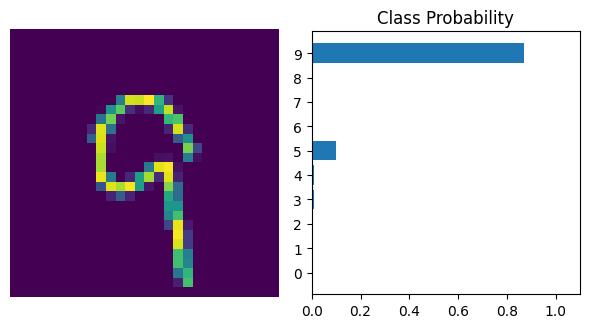

In [15]:
#EXAMPLE CASES OF MODEL-USE

images, labels = next(iter(valloader))

img = images[2].view(1, 784)
# Turn off gradients to speed up
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [30]:
#EVALUATE USING TEST DATA

correct = 0
all = 0 

for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
      
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    #Network output log-probabilities with LogSoftmax so exp back to standard probs
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
      
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
      
    if(true_label == pred_label):
      correct += 1
    all += 1

print("Number Of Images Tested =", all)
print("Model Accuracy =", (correct/all))

Number Of Images Tested = 10000
Model Accuracy = 0.9708


zsh:1: no matches found: nbconvert[webpdf]
Note: you may need to restart the kernel to use updated packages.
